Imports

In [2]:
from sklearn.datasets import fetch_openml
from keras.utils.np_utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time


Loading MNIST dataset

In [12]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

print(x_train.shape)
print(x_val.shape)

(59500, 784)
(10500, 784)


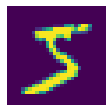

In [4]:
def show_digit(digit):
  digit_pixels = digit.reshape(28, 28)
  plt.subplot(131)
  plt.imshow(digit_pixels)
  plt.axis('off')

show_digit(x[0])

In [5]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Image Augmentation - using random image rotation

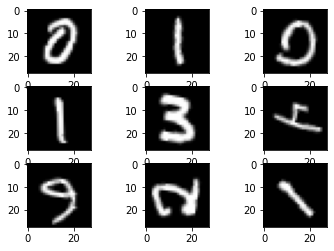

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

x_train_aug = x_train.reshape((x_train.shape[0], 28, 28, 1))
datagen = ImageDataGenerator(rotation_range=90)
# fit parameters from data
datagen.fit(x_train_aug)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(x_train_aug, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break

In [10]:
def rotate_image(x, y):
  from keras.preprocessing.image import ImageDataGenerator
  x = x.reshape((x.shape[0], 28, 28, 1))
  datagen = ImageDataGenerator(rotation_range=90)
  datagen.fit(x)

  for x_aug, y_aug in datagen.flow(x, y, batch_size=10000):
    return x_aug, y_aug

In [13]:
x_train_aug, y_train_aug = rotate_image(x_train, y_train)
x_test_aug, y_test_aug = rotate_image(x_val, y_val)

x_train_aug = x_train_aug.reshape(x_train_aug.shape[0], 784)
x_test_aug = x_test_aug.reshape(x_test_aug.shape[0], 784)

print(x_train_aug.shape)
print(x_test_aug.shape)

x_train = np.concatenate((x_train, x_train_aug), axis=0)
y_train = np.concatenate((y_train, y_train_aug), axis=0)

x_val = np.concatenate((x_val, x_test_aug), axis=0)
y_val = np.concatenate((y_val, y_test_aug), axis=0)

print(x_train.shape)
print(x_val.shape)

(10000, 784)
(10000, 784)
(69500, 784)
(20500, 784)


DNN implemention with 3 layers

In [14]:
class Relu:
  def __call__(self, input_):
    self.input = input_
    self.output = np.clip(self.input, 0, None)
    return self.output

  def backward(self, gradient):
    self.input_gradient = (self.input > 0) * gradient
    return self.input_gradient

In [15]:
class DeepNeuralNetwork:
  def __init__(self, sizes, epochs=10, lr=0.001):
    self.sizes = sizes
    self.epochs = epochs
    self.lr = lr
    self.params = self.initialization()

  def initialization(self):
    input_layer=self.sizes[0]
    hidden_1=self.sizes[1]
    hidden_2=self.sizes[2]
    output_layer=self.sizes[3]

    params = {
        'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
        'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
        'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
        'B1': np.zeros(1),
        'B2': np.zeros(1),
        'B3': np.zeros(1),
    }
    return params

  def relu(self, data, derivative=False):
    if derivative:
      return  (data > 0) * 1
    return np.clip(data, 0, None)

  def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

  def forward(self, data):
    params = self.params

    params['A0'] = data

    params['Z1'] = np.dot(params['W1'], params['A0']) + params['B1']
    params['A1'] = self.relu(params['Z1'])

    params['Z2'] = np.dot(params['W2'], params['A1']) + params['B2']
    params['A2'] = self.relu(params['Z2'])

    params['Z3'] = np.dot(params['W3'], params['A2']) + params['B3']
    params['A3'] = self.softmax(params['Z3'])

    return params['A3']

  def backward(self, y_train, output):
    params = self.params
    change_w = {}

    # Calculate W3 update
    error = 2 * (output - pd.to_numeric(y_train)) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
    change_w['W3'] = np.outer(error, params['A2'])
    change_w['B3'] = error.sum()

    # Calculate W2 update
    error = np.dot(params['W3'].T, error) * self.relu(params['Z2'], derivative=True)
    change_w['W2'] = np.outer(error, params['A1'])
    change_w['B2'] = error.sum()

    # Calculate W1 update
    error = np.dot(params['W2'].T, error) * self.relu(params['Z1'], derivative=True)
    change_w['W1'] = np.outer(error, params['A0'])
    change_w['B1'] = error.sum()

    return change_w

  
  def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

  def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                output = self.forward(x)
                changes_to_w = self.backward(y, output)
                self.update_network_parameters(changes_to_w)
            
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))

  def update_network_parameters(self, changes_to_w):
     for key, value in changes_to_w.items():
       self.params[key] -= self.lr * value
   
  def compute_accuracy(self, x_val, y_val):
      predictions = []

      for x, y in zip(x_val, y_val):
          output = self.forward(x)
          pred = np.argmax(output)
          y = np.argmax(y)
          predictions.append(pred == y)

      return np.mean(predictions)





In [16]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10])
dnn.train(x_train, y_train, x_val, y_val)

Epoch: 1, Time Spent: 77.40s, Accuracy: 57.21%
Epoch: 2, Time Spent: 157.93s, Accuracy: 63.50%
Epoch: 3, Time Spent: 235.93s, Accuracy: 66.88%
Epoch: 4, Time Spent: 313.12s, Accuracy: 69.10%
Epoch: 5, Time Spent: 390.71s, Accuracy: 71.19%
Epoch: 6, Time Spent: 469.20s, Accuracy: 72.56%
Epoch: 7, Time Spent: 546.61s, Accuracy: 73.31%
Epoch: 8, Time Spent: 623.86s, Accuracy: 74.16%
Epoch: 9, Time Spent: 701.91s, Accuracy: 74.96%
Epoch: 10, Time Spent: 780.28s, Accuracy: 75.42%
